# 📊 YouTube Channel Performance Analysis

Predicting revenue and analyzing engagement using video-level metrics.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Dataset
df = pd.read_csv("youtube_channel_real_performance_analytics.csv")
df['Video Publish Time'] = pd.to_datetime(df['Video Publish Time'])
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  364 non-null    int64         
 1   Video Duration                      364 non-null    float64       
 2   Video Publish Time                  364 non-null    datetime64[ns]
 3   Days Since Publish                  364 non-null    int64         
 4   Day                                 364 non-null    int64         
 5   Month                               364 non-null    int64         
 6   Year                                364 non-null    int64         
 7   Day of Week                         364 non-null    object        
 8   Revenue per 1000 Views (USD)        364 non-null    float64       
 9   Monetized Playbacks (Estimate)      364 non-null    float64       
 10  Playback-Based CPM (USD)  

,ID,Video Duration,Video Publish Time,Days Since Publish,Day,Month,Year,Day of Week,Revenue per 1000 Views (USD),Monetized Playbacks (Estimate),...,Watched (Not Skipped) (%),Feed Impressions,Average View Percentage (%),Average View Duration,Views,Watch Time (hours),Subscribers,Estimated Revenue (USD),Impressions,Video Thumbnail CTR (%)
0,0,201.0,2016-06-02,0,2,6,2016,Thursday,0.024,723.0,...,0.0,0.0,40.38,81.0,23531.0,533.1636,51.0,0.561,41118.0,27.66
1,1,391.0,2016-06-10,8,10,6,2016,Friday,0.056,727.0,...,0.0,0.0,39.85,156.0,11478.0,500.5628,33.0,0.648,41627.0,5.85
2,2,133.0,2016-06-14,4,14,6,2016,Tuesday,0.014,76.0,...,0.0,0.0,30.88,41.0,6153.0,70.7287,8.0,0.089,38713.0,7.07
3,3,14.0,2016-06-29,15,29,6,2016,Wednesday,0.004,18.0,...,0.0,0.0,103.05,14.0,4398.0,17.6251,2.0,0.017,35245.0,5.60
4,4,45.0,2016-07-01,2,1,7,2016,Friday,0.000,0.0,...,0.0,0.0,55.70,25.0,14659.0,104.3341,28.0,0.000,46218.0,8.62


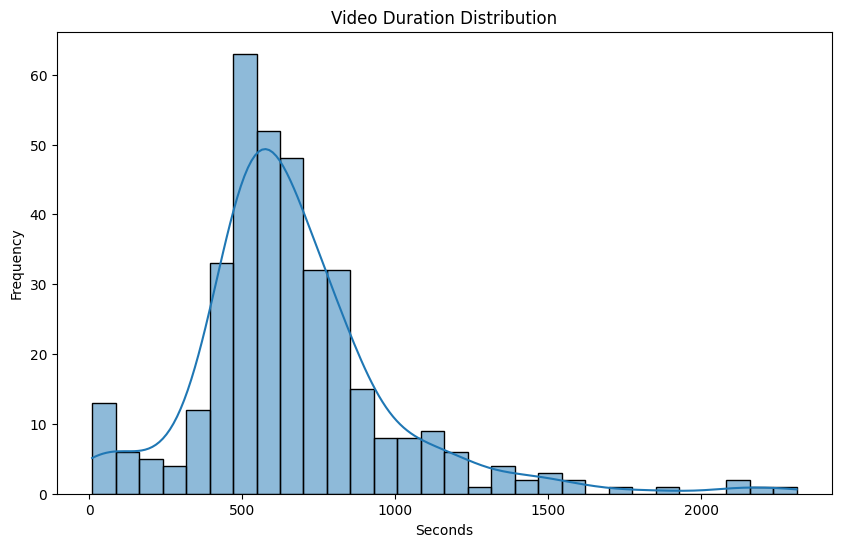

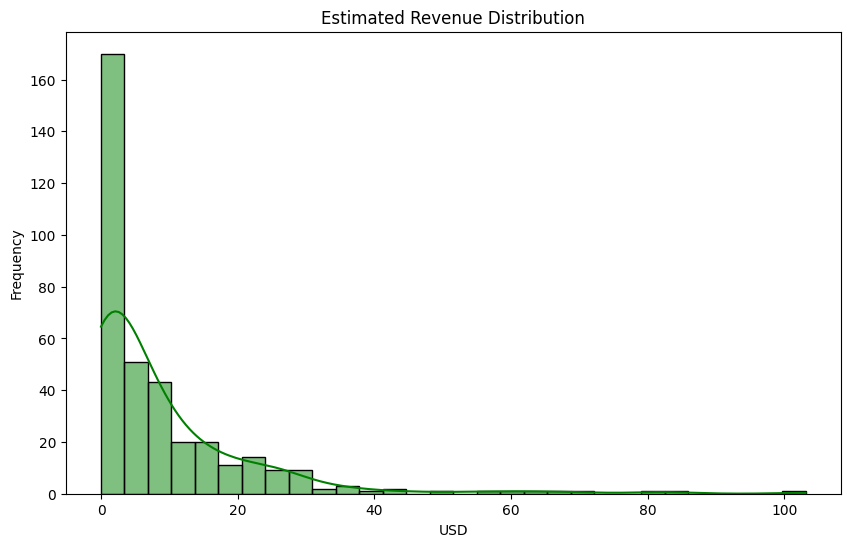

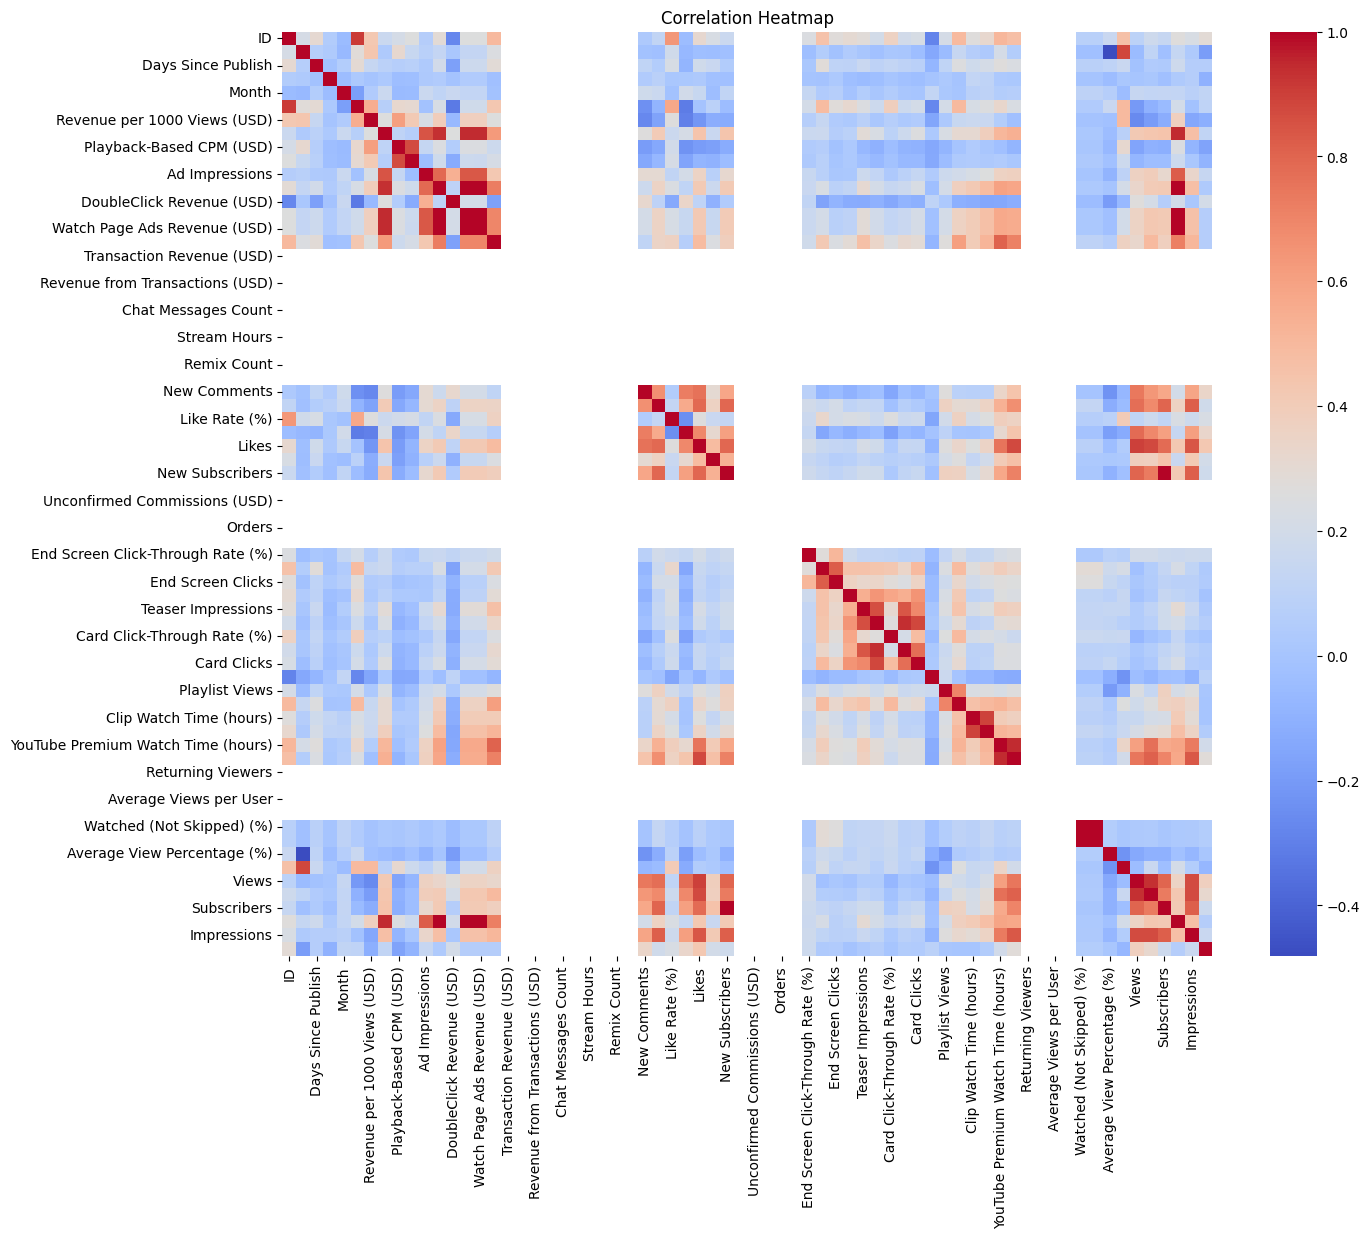

In [3]:
# Video Duration Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Video Duration'], bins=30, kde=True)
plt.title('Video Duration Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

# Revenue Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Estimated Revenue (USD)'], bins=30, kde=True, color='green')
plt.title('Estimated Revenue Distribution')
plt.xlabel('USD')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(15,12))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [7]:
print(df.columns.tolist())


['ID', 'Video Duration', 'Video Publish Time', 'Days Since Publish', 'Day', 'Month', 'Year', 'Day of Week', 'Revenue per 1000 Views (USD)', 'Monetized Playbacks (Estimate)', 'Playback-Based CPM (USD)', 'CPM (USD)', 'Ad Impressions', 'Estimated AdSense Revenue (USD)', 'DoubleClick Revenue (USD)', 'YouTube Ads Revenue (USD)', 'Watch Page Ads Revenue (USD)', 'YouTube\xa0Premium (USD)', 'Transaction Revenue (USD)', 'Transactions', 'Revenue from Transactions (USD)', 'Reactions', 'Chat Messages Count', 'Reminders Set', 'Stream Hours', 'Remix Views', 'Remix Count', 'Subscribers from Posts', 'New Comments', 'Shares', 'Like Rate (%)', 'Dislikes', 'Likes', 'Unsubscribes', 'New Subscribers', 'Returned Items (USD)', 'Unconfirmed Commissions (USD)', 'Approved Commissions (USD)', 'Orders', 'Total Sales Volume (USD)', 'End Screen Click-Through Rate (%)', 'End Screen Impressions', 'End Screen Clicks', 'Teaser Click-Through Rate (%)', 'Teaser Impressions', 'Teaser Clicks', 'Card Click-Through Rate (%)'

In [8]:
# Feature Engineering
# Use actual column names
df[['Likes', 'Shares', 'New Comments', 'Views', 'Estimated Revenue (USD)']] = \
    df[['Likes', 'Shares', 'New Comments', 'Views', 'Estimated Revenue (USD)']].fillna(0)

# Revenue per View
df['Revenue per View'] = np.where(
    df['Views'] == 0,
    0,
    df['Estimated Revenue (USD)'] / df['Views']
)

# Engagement Rate using 'New Comments' instead of 'Comments'
df['Engagement Rate'] = np.where(
    df['Views'] == 0,
    0,
    (df['Likes'] + df['Shares'] + df['New Comments']) / df['Views'] * 100
)

# Clean up any infinities
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [10]:
# Features and Target
# Update features list based on actual column names in your dataset
features = ['Views', 'Subscribers', 'Likes', 'Shares', 'New Comments', 'Engagement Rate']
target = 'Estimated Revenue (USD)'

# Validate that all feature columns exist
missing_features = [col for col in features if col not in df.columns]
if missing_features:
    raise ValueError(f"Missing features in DataFrame: {missing_features}")

# Split features and target
X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R-squared: {r2:.2f}")


RMSE: 8.70
R-squared: 0.13


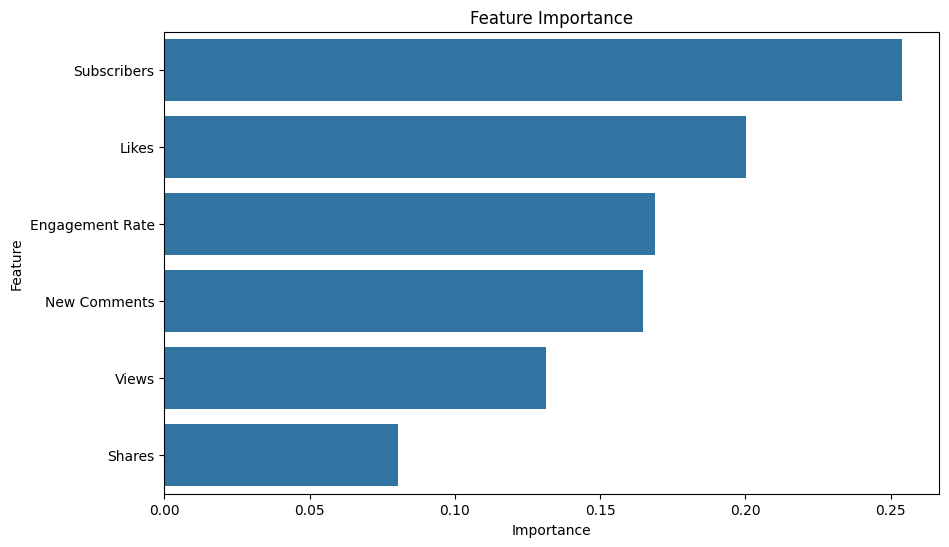

In [11]:
# Feature Importance
importances = model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance")
plt.show()


In [12]:
# Save model as pickle
joblib.dump(model, 'youtube_revenue_predictor.pkl')


['youtube_revenue_predictor.pkl']